In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df=pd.read_parquet("../data/processed/sp500.parquet")

In [3]:
df.columns


Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Sector', 'Industry', 'return_1d', 'return_5d', 'return_20d', 'ma_5d',
       'ma_20d', 'ema_5d', 'ema_20d', 'rv_5d', 'rv_20d', 'week_of_year',
       'month', 'quarter', 'hl_range', 'vol_change', 'oc_diff', 'gap', 'rsi',
       'macd', 'macd_signal', 'macd_hist', 'target_1d', 'target_5d',
       'target_20d', 'day_of_week', 'day_of_month', 'is_quarter_start',
       'is_quarter_end', 'sp500_Adj Close', 'sp500_Volume', 'sp500_return_10d',
       'sp500_return_20d', 'sp500_ma_10d', 'sp500_ema_20d', 'sp500_rv_20d',
       'sp500_hl_range', 'sp500_vol_change', 'sp500_oc_diff', 'sp500_gap',
       'sp500_rsi', 'sp500_macd_signal', 'sp500_macd_hist', 'bollinger_width',
       'atr_14d', 'atr_14d_norm', 'obv', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHh_14_3_3', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14',
       'sp500_ema_30d', 'sp500_ema_60d', 'sp500_ema_90d', 'WR_14', 'WR_5',
       'CCI_20', 'CCI_1

In [ ]:
#create pipeline one hot encode cat and scale categorical columns
def create_pipeline(X, model=LinearRegression()):
    num_col=X.select_dtypes(include=[np.number]).columns.tolist()
    cat_col=X.select_dtypes(exclude=[np.number,'datetime']).columns.tolist() 
    cat_col_filters=['Industry','Sector']
    cat_col=[x for x in cat_col if x not in cat_col_filters]
    preprocessing=ColumnTransformer([
        ('num',StandardScaler(),num_col),
        ('cat',OneHotEncoder(handle_unknown='ignore'),cat_col)
    ])
    pipeline=Pipeline(steps=[
        ('preprocessing',preprocessing),
        ('model',model)
    ])
    return pipeline

In [ ]:
def split_test_train_sp500(df, test_start, validation_start):
    train = df[df["Date"] < validation_start]
    validation = df[(df["Date"] >= validation_start) & (df["Date"] < test_start)]
    test = df[df["Date"] >= test_start]

    drop_cols=["target_1d","target_5d","target_20d","Date"]
    X_train = train.drop(columns=drop_cols)
    y_train = train["target_5d"].to_numpy()

    X_valid = validation.drop(columns=drop_cols)
    y_valid = validation["target_5d"].to_numpy()

    X_test = test.drop(columns=drop_cols)
    y_test = test["target_5d"].to_numpy()

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)


In [ ]:
def train_and_evaluate(pipeline, X_train, y_train, X_valid, y_valid):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_valid_pred = pipeline.predict(X_valid)

    # Directional Accuracy for train
    baseline=np.mean(y_valid>0)
    print("Baseline for Validation:",baseline)
    directional_accuracy = np.mean(np.sign(y_train_pred) == np.sign(y_train))
    print(f"Directional Accuracy Train: {directional_accuracy:.2%}")

    # Directional Accuracy for valid
    directional_accuracy = np.mean(np.sign(y_valid_pred) == np.sign(y_valid))
    print(f"Directional Accuracy Validation: {directional_accuracy:.2%}")
    
    return pipeline


In [ ]:
#thoughts 
#l2 regression only gave a 53.72% accuracy which would be lower than just guessing that the stock goes up
#means that the model is not learning any valuable trends or there is no strong correlation of features in what i currently have
#since i tried different alpha values to check if the model is overfitting or underfitting neither really changed the performancec
#2 ways i can take this
#try and find other features i can engineer that have stronger correlation with swing trading
#use stronger model to see if it can learn better
#directional accuracy does not really mean the accuracy of the model but since r2 and mape are off since very low value i will keep it
#steps for tomorrow
#check a few features i can add to see if they improve the performance of this model
#if not pivot and use a stronger model

In [ ]:
#testing linear regression
test_start="2024-01-01"
validation_start="2023-01-01"
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_test_train_sp500(df, test_start, validation_start)
pipeline=create_pipeline(X_train)
pipeline = train_and_evaluate(pipeline, X_train, y_train, X_valid, y_valid)

Baseline for Validation: 0.5384282589711338
Directional Accuracy Train: 54.38%
Directional Accuracy Validation: 53.40%


In [ ]:
pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
#testing random forest
test_start="2024-01-01"
validation_start="2023-01-01"
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_test_train_sp500(df, test_start, validation_start)
pipeline=create_pipeline(X_train,RandomForestRegressor(n_estimators=100,
                                                        n_jobs=-1,
                                                        min_samples_leaf=32,
                                                        max_features="sqrt",
                                                        random_state=42
                                                       )) # type: ignore

pipeline = train_and_evaluate(pipeline, X_train, y_train, X_valid, y_valid)



Python(54472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Baseline for Validation: 0.5384288747346072
Directional Accuracy Train: 74.79%
Directional Accuracy Validation: 55.05%


In [ ]:
#i will try adda boost and xgboost to see if they can improve my accuracy
#adaboost uses stumps and makes it so one stump influences the making of the other stump
#in random forest every tree has an equal say not in adaboost
test_start="2024-01-01"
validation_start="2023-01-01"
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_test_train_sp500(df, test_start, validation_start)
pipeline=create_pipeline(X_train, AdaBoostRegressor(n_estimators=150,
                                                    learning_rate=0.5,
                                                    random_state=42)) # type: ignore
pipeline = train_and_evaluate(pipeline, X_train, y_train, X_valid, y_valid)

Baseline for Validation: 0.538464618637281
Directional Accuracy Train: 55.18%
Directional Accuracy Validation: 53.85%


In [ ]:
#next i will actually try using xgboost which performs better than randomforest
#hope is to touch 60 percent accuracy which would give me an edge in trading
#i plan on using RNN (LSTM) to train a neural network and see if its better than all the algorithms mentioned
#if xg boost proves to be better i might look into hyperparameter tuning before I move on from it 
test_start="2024-01-01"
validation_start="2023-01-01"
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_test_train_sp500(df, test_start, validation_start)
pipeline=create_pipeline(X_train, XGBRegressor(
        n_estimators=200,
        learning_rate=0.0005,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1
    )) # type: ignore
pipeline = train_and_evaluate(pipeline, X_train, y_train, X_valid, y_valid)

Baseline for Validation: 0.5384282589711338
Directional Accuracy Train: 55.09%
Directional Accuracy Validation: 53.84%


<Figure size 1000x600 with 0 Axes>

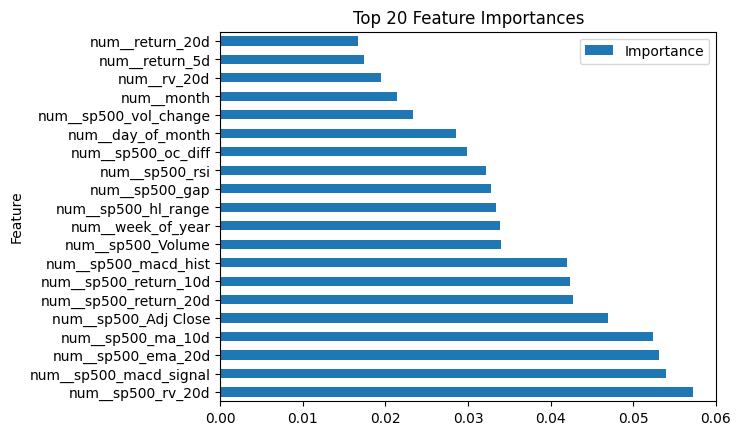

In [ ]:
def plot_feature_importance(pipeline):
    # If you used a ColumnTransformer in your pipeline
    preprocessor = pipeline.named_steps["preprocessing"]  # whatever you called it
    feature_names = preprocessor.get_feature_names_out()

    # Now these should match the model's feature importances
    feature_importances = pipeline.named_steps["model"].feature_importances_

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False 
                ).reset_index(drop=True)

    importance_df.head(45)
    # Optional: visualize
    plt.figure(figsize=(10,6))
    importance_df.head(20).plot(kind='barh', x="Feature", y="Importance")
    plt.title("Top 20 Feature Importances")
    plt.show()

In [ ]:
#linear regression accuracy
test_start="2024-01-01"
validation_start="2023-01-01"
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_test_train_sp500(new_df, test_start, validation_start)
pipeline=create_pipeline(X_train)
pipeline = train_and_evaluate(pipeline, X_train, y_train, X_valid, y_valid)


Baseline for Validation: 0.5384282589711338
Directional Accuracy Train: 54.22%
Directional Accuracy Validation: 52.99%


In [ ]:
drop_cols = ["Date", "target_1d", "target_5d", "target_20d"]
model=model=XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
param_dis={
        'model__n_estimators':[50,100,150,200],
        "model__max_depth":[3,5,7],
        "model__learning_rate":[0.001,0.1,0.05],
        'model__subsample':[0.5,0.6,0.8,1],
        "model__colsample_bytree":[0.6,0.5,0.8],
        "model__gamma":[0.2,0.1,0.3]
    }


In [ ]:
# i will now hyper parameter tune an xgboost model to see how well it performs in my stock data
#i think i have included 
def hyper_parameter_tuning(model,drop_cols,df,params, split=5):
    #split target and feature 
    X=df.drop(columns=drop_cols)
    y=df["target_5d"].to_numpy()

    #create a pipeline to encode data and use model

    pipeline = create_pipeline(X,model) # type: ignore

    #split data
    tscv=TimeSeriesSplit(n_splits=split)

    #use given params to tune the model

    fine_tuned_model = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=20,
        scoring="neg_mean_squared_error",
        cv=tscv,
        verbose=2,
        random_state=42
    )
    #fit the model
    fine_tuned_model.fit(X,y)


    #show statistics
    print("Best parameters found:", fine_tuned_model.best_params_)
    print("Best CV score (MSE):", -fine_tuned_model.best_score_)
    print("Best CV score (RMSE):", (-fine_tuned_model.best_score_)**0.5)

    return fine_tuned_model

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   7.9s
[CV] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=  13.2s
[CV] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=  20.5s
[CV] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=  47.5s
[CV] END model__colsample_bytree=0.5, model__gamma=0.1, model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time= 1.3min
[CV] END model__colsample_bytree=0.6, model__gamma=0.3, model__learning_rate=0.1, model_

,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__colsample_bytree': [0.6, 0.5, ...], 'model__gamma': [0.2, 0.1, ...], 'model__learning_rate': [0.001, 0.1, ...], 'model__max_depth': [3, 5, ...], ...}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
#learned that i can hold out some portion of my data as a simulation for live testing
# train_size=int(len(X)*0.8)

# X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# refit_model=random_search.best_estimator_
# refit_model.fit(X_train,y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# Regression metrics
def evaluate_model(y,y_hat):
    #Standard accuracy metrics
    mse = mean_squared_error(y, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_hat)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R^2: {r2:.4f}")
    

    # Directional accuracy
    directional_accuracy = np.mean(np.sign(y_hat) == np.sign(y))
    print(f"Directional Accuracy: {directional_accuracy:.2%}")

Test MSE: 0.0019
Test RMSE: 0.0432
Test R^2: 0.1933
Directional Accuracy: 63.06%


In [ ]:
#calculating the sharpe ratio
#take long when prediction>0 and short when prediction<0


In [ ]:
#save the model cause it's pretty good
model= joblib.load("../models/xgb_stock_model.pkl")

In [ ]:
y_pred=model.predict(X_test)
directional_accuracy=np.mean(np.sign(y_pred)==np.sign(y_test))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 63.57%


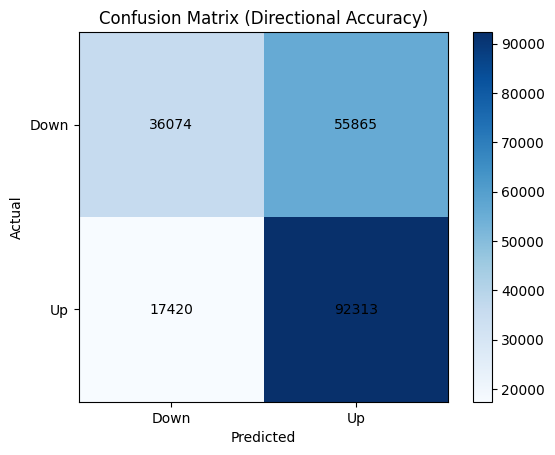

In [ ]:
def show_confusion_matrix(X_test,y_test,model):
    fig, ax = plt.subplots()
    y_pred=model.predict(X_test)
    y_true_dir = np.sign(y_test)
    y_pred_dir = np.sign(y_pred)


    cm = confusion_matrix(y_true_dir, y_pred_dir, labels=[-1, 1])
    im = ax.imshow(cm, cmap="Blues")

    # Add labels
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(["Down", "Up"])
    ax.set_yticklabels(["Down", "Up"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Annotate cells
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.title("Confusion Matrix (Directional Accuracy)")
    plt.colorbar(im, ax=ax)
    plt.show()
